# Algorithmic Fairness, Accountability, and Ethics, Spring 2024

## Mandatory Assignment 1

Please use the following code to prepare the dataset.
 

In [17]:
# imports
from sklearn.ensemble import RandomForestClassifier
from folktables.acs import adult_filter
from folktables import ACSDataSource
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt


In [3]:
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)

feature_names = ['AGEP', # Age
                 "CIT", # Citizenship status
                 'COW', # Class of worker
                 "ENG", # Ability to speak English
                 'SCHL', # Educational attainment
                 'MAR', # Marital status
                 "HINS1", # Insurance through a current or former employer or union
                 "HINS2", # Insurance purchased directly from an insurance company
                 "HINS4", # Medicaid
                 "RAC1P", # Recoded detailed race code
                 'SEX']

target_name = "PINCP" # Total person's income

def data_processing(data, features, target_name:str, threshold: float = 35000):
    df = data
    ### Adult Filter (STARTS) (from Foltktables)
    df = df[~df["SEX"].isnull()]
    df = df[~df["RAC1P"].isnull()]
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    ### Adult Filter (ENDS)
    ### Groups of interest
    sex = df["SEX"].values
    ### Target
    df["target"] = df[target_name] > threshold
    target = df["target"].values
    df = df[features + ["target", target_name]] ##we want to keep df before one_hot encoding to make Bias Analysis
    df_processed = df[features].copy()
    cols = {
        "HINS1": 'HINS1_2.0',
        "HINS2": 'HINS2_2.0',
        "HINS4": 'HINS4_2.0',
        "CIT": 'CIT_1.0',
        "COW" : 'COW_1.0',
        "SCHL" : 'SCHL_16.0',
        "MAR": 'MAR_5.0',
        "SEX": 'SEX_1.0',
        "RAC1P" :'RAC1P_1.0',
        "ENG" : 'ENG_1.0',
        }
    drop_cols = []
    for i in cols: 
        if cols[i] == '':
            drop_first = f'{i}_{df_processed[i].value_counts().idxmax()}'
            cols[i] = drop_first
        else:
            drop_first = cols[i]
        drop_cols.append(drop_first)
        df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=True, columns=[i]) ; df_processed.drop(columns=drop_first, inplace=True)
    return df_processed, df, target, sex, cols

data, data_original, target, group, cols = data_processing(acs_data, feature_names, target_name)

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    data, target, group, test_size=0.2, random_state=0)

In [4]:
scaler = MinMaxScaler()
X_train[["AGEP"]] = scaler.fit_transform(X_train[["AGEP"]])
X_test[["AGEP"]] = scaler.fit_transform(X_test[["AGEP"]])

In [5]:
model = LogisticRegression(max_iter=5000, penalty= "l2", C= 0.8497534359086438, tol=1e-4, solver = "saga")
model.fit(X_train, y_train)

LogisticRegression(C=0.8497534359086438, max_iter=5000, solver='saga')

In [6]:
#model = make_pipeline(MinMaxScaler(), LogisticRegression(max_iter=5000, penalty= "l2", C= 0.8497534359086438, tol=1e-4, solver = "saga"))
#model.fit(X_train, y_train)
predictions = model.predict(X_test)


In [7]:
model.score(X_test, y_test)

0.7696573224644162

In [8]:
def evaluate_pipeline(pipeline, X_train, y_train, X_test, y_test, threshold1, threshold2):
    global s1, s2, preds_s1, preds_s2, true_s1, true_s2, fpr1, tpr1, thresholds1, fpr2, tpr2, thresholds2, scores_s1, scores_s2   
    pipeline.fit(X_train, y_train)
    # y_pred = pipeline.predict(X_test)
    # Modify pipeline to fulfill one of the fairness criteria (e.g. statistical parity, equal opportunity, etc.)
    X_test = X_test.reset_index(drop=True)
    s2 = X_test.loc[X_test['SEX_2.0'] == True] 
    s1 = X_test.loc[X_test['SEX_2.0'] == False]

    true_s1 = []
    for i in s1.index:
        true_s1.append(y_test[i])
    true_s2 = []
    for i in s2.index:
        true_s2.append(y_test[i])


    scores_s1 = pipeline.predict_proba(s1)[:, 1]
    fpr1, tpr1, thresholds1 = roc_curve(true_s1, scores_s1, pos_label=1)
    scores_s2 = pipeline.predict_proba(s2)[:, 1]
    fpr2, tpr2, thresholds2 = roc_curve(true_s2, scores_s2, pos_label=1)


    preds_s1 = scores_s1 > threshold1
    preds_s2 = scores_s2 > threshold2
    return pipeline

In [9]:
# Needed to make sure logisric regression converges
X_train['AGEP'] = MinMaxScaler().fit_transform(X_train[['AGEP']])
X_test['AGEP'] = MinMaxScaler().fit_transform(X_test[['AGEP']])

In [10]:
rf_args = {
    'n_estimators': 100, # changed from 100
    'max_depth' : 10, #changed from 10
    'min_samples_split': 2, #changed from 2
    'min_samples_leaf': 2, #changed from 2
    'random_state': 0
}
lr_model = LogisticRegression(max_iter=5000, penalty= "l2", C= 0.8497534359086438, tol=1e-4, solver = "saga", random_state=0)
p1 = make_pipeline(RandomForestClassifier(**rf_args))
p2 = make_pipeline(lr_model)

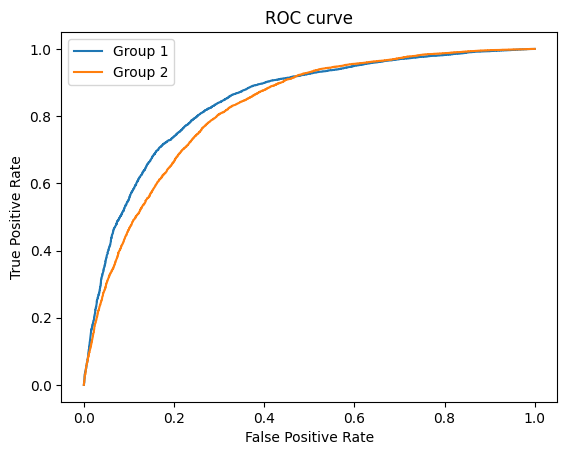

Accuracy for group 1:  0.786479802143446
Accuracy for group 2:  0.7508643042350908
Selection rate for s1:  0.6419184326657291
Selection rate for s2:  0.5171240276577356
Statistical parity:  0.12479440500799355


In [11]:
p2_done = evaluate_pipeline(p2, X_train, y_train, X_test, y_test, 0.5, 0.5)

plt.plot(fpr1, tpr1, label='Group 1')
plt.plot(fpr2, tpr2, label='Group 2')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Calculate Youden's J statistic for each model
youden_j1 = tpr1 - fpr1
optimal_threshold_index1 = np.argmax(youden_j1)
optimal_threshold1 = thresholds1[optimal_threshold_index1]

youden_j2 = tpr2 - fpr2
optimal_threshold_index2 = np.argmax(youden_j2)
optimal_threshold2 = thresholds2[optimal_threshold_index2]
preds_s1 = scores_s1 > 0.5 # 0.66 best 
preds_s2 = scores_s2 > 0.5 # 0.4756088801681863 best

print("Accuracy for group 1: ", accuracy_score(true_s1, preds_s1))
print("Accuracy for group 2: ", accuracy_score(true_s2, preds_s2))

print('Selection rate for s1: ', np.sum(preds_s1)/len(s1))
print('Selection rate for s2: ', np.sum(preds_s2)/len(s2))

sp1 = np.sum(preds_s1)/len(s1)
sp2 = np.sum(preds_s2)/len(s2)
print('Statistical parity: ', abs(sp1 - sp2))

In [12]:
def get_tpr_fnr_fpr_tnr(cm):
    """
    This function returns class-wise TPR, FNR, FPR & TNR
    [[cm]]: a 2-D array of a multiclass confusion matrix
            where horizontal axes represent actual classes
            and vertical axes represent predicted classes
    {output}: a dictionary of class-wise accuracy parameters
    """
    dict_metric = dict()
    n = len(cm[0])
    row_sums = cm.sum(axis=1)
    col_sums = cm.sum(axis=0)
    array_sum = sum(sum(cm))
    #initialize a blank nested dictionary
    for i in range(1, n+1):
        keys = str(i)
        dict_metric[keys] = {"TPR":0, "FNR":0, "FPR":0, "TNR":0}
    # calculate and store class-wise TPR, FNR, FPR, TNR
    for i in range(n):
        for j in range(n):
            if i == j:
                keys = str(i+1)
                tp = cm[i, j]
                fn = row_sums[i] - cm[i, j]
                dict_metric[keys]["TPR"] = tp / (tp + fn)
                dict_metric[keys]["FNR"] = fn / (tp + fn)
                fp = col_sums[i] - cm[i, j]
                tn = array_sum - tp - fn - fp
                dict_metric[keys]["FPR"] = fp / (fp + tn)
                dict_metric[keys]["TNR"] = tn / (fp + tn)
    return dict_metric

In [13]:
confusion_matrix(true_s2, preds_s2)

array([[6875, 2548],
       [2064, 7025]], dtype=int64)

In [14]:
df1 = pd.DataFrame(get_tpr_fnr_fpr_tnr(confusion_matrix(true_s1, preds_s1))).transpose()
df2 = pd.DataFrame(get_tpr_fnr_fpr_tnr(confusion_matrix(true_s2, preds_s2))).transpose()

In [15]:
df1

,TPR,FNR,FPR,TNR
1,0.684811,0.315189,0.148216,0.851784
2,0.851784,0.148216,0.315189,0.684811


In [16]:
df2

,TPR,FNR,FPR,TNR
1,0.729598,0.270402,0.227088,0.772912
2,0.772912,0.227088,0.270402,0.729598


In [19]:
tpr1 = np.sum(preds_s1 & true_s1)/np.sum(true_s1)
tpr2 = np.sum(preds_s2 & true_s2)/np.sum(true_s2)

fpr1 = np.sum(preds_s1 & true_s1)/np.sum(true_s1)
fpr2 = np.sum(preds_s2 & true_s2)/np.sum(true_s2)

tnr1 = 1 - fpr1
tnr2 = 1 - fpr2

fnr1 = 1 - tpr1
fnr2 = 1 - tpr2

print('True positive rate for s1: ', tpr1)
print('True positive rate for s2: ', tpr2)
print('False positive rate for s1: ', fpr1)
print('False positive rate for s2: ', fpr2)
print('True negative rate for s1: ', tnr1)
print('True negative rate for s2: ', tnr2)
print('False negative rate for s1: ', fnr1)
print('False negative rate for s2: ', fnr2)

True positive rate for s1:  0.851784007645747
True positive rate for s2:  0.7729123115854329
False positive rate for s1:  0.851784007645747
False positive rate for s2:  0.7729123115854329
True negative rate for s1:  0.14821599235425298
True negative rate for s2:  0.22708768841456706
False negative rate for s1:  0.14821599235425298
False negative rate for s2:  0.22708768841456706


In [20]:
tpr2

0.7729123115854329

In [22]:
# calculating statistical parity, equalized outcomes, and equalized odds
sp1 = np.sum(preds_s1)/len(s1)
sp2 = np.sum(preds_s2)/len(s2)
accuracy_s1 = accuracy_score(true_s1, preds_s1)
accuracy_s2 = accuracy_score(true_s2, preds_s2)
selection_rate_s1 = np.sum(preds_s1)/len(s1)
selection_rate_s2 = np.sum(preds_s2)/len(s2)


In [12]:
preds_s1 = model.predict_proba(s1)[:,1]
preds_s2 = model.predict_proba(s2)[:,1]

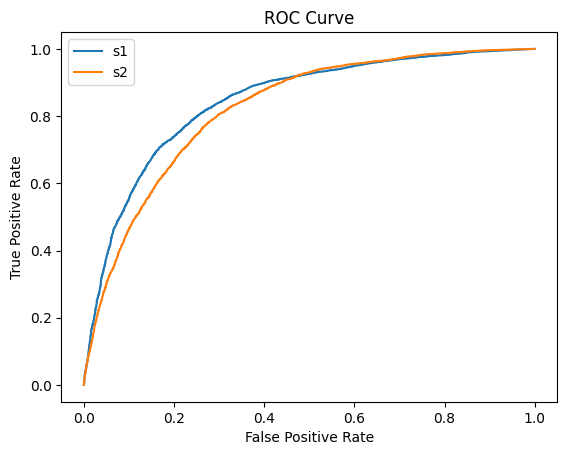

In [14]:
fpr1, tpr1, thresholds1 = roc_curve(true_s1, preds_s1, drop_intermediate=False)
fpr2, tpr2, thresholds2 = roc_curve(true_s2, preds_s2, drop_intermediate=False)

# Plot ROC curve for s1
plt.plot(fpr1, tpr1, label='s1')
# Plot ROC curve for s2
plt.plot(fpr2, tpr2, label='s2')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Show the plot
plt.show()


In [24]:
model.score(X_test, y_test)
# Retrieve the coefficients of the logistic regression model
coefficients = model.coef_[0]
# Compute the odds ratio
odds_ratio = np.exp(coefficients)

std_error = np.std(X_train, axis=0) * coefficients
coefficients_df = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': coefficients, 'Odds ratio': odds_ratio, 'Standard error': std_error})
# Sort the dataframe by coefficient values in descending order
coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)

# Display the dataframe
coefficients_df


,Feature,Coefficient,Odds ratio,Standard error
AGEP,AGEP,2.876676,17.755165,0.556314
SCHL_24.0,SCHL_24.0,2.013611,7.490316,0.280949
SCHL_23.0,SCHL_23.0,1.984848,7.277943,0.330804
SCHL_22.0,SCHL_22.0,1.796235,6.026911,0.539616
SCHL_21.0,SCHL_21.0,1.295871,3.654176,0.551845
...,...,...,...,...
SEX_2.0,SEX_2.0,-0.819072,0.440841,-0.408881
HINS4_1.0,HINS4_1.0,-0.835320,0.433736,-0.292428
SCHL_4.0,SCHL_4.0,-0.870372,0.418796,-0.020395
ENG_4.0,ENG_4.0,-0.978805,0.375760,-0.134485


In [25]:
print(list(X_test))

['AGEP', 'HINS1_1.0', 'HINS1_nan', 'HINS2_1.0', 'HINS2_nan', 'HINS4_1.0', 'HINS4_nan', 'CIT_2.0', 'CIT_3.0', 'CIT_4.0', 'CIT_5.0', 'CIT_nan', 'COW_2.0', 'COW_3.0', 'COW_4.0', 'COW_5.0', 'COW_6.0', 'COW_7.0', 'COW_8.0', 'COW_nan', 'SCHL_1.0', 'SCHL_2.0', 'SCHL_3.0', 'SCHL_4.0', 'SCHL_5.0', 'SCHL_6.0', 'SCHL_7.0', 'SCHL_8.0', 'SCHL_9.0', 'SCHL_10.0', 'SCHL_11.0', 'SCHL_12.0', 'SCHL_13.0', 'SCHL_14.0', 'SCHL_15.0', 'SCHL_17.0', 'SCHL_18.0', 'SCHL_19.0', 'SCHL_20.0', 'SCHL_21.0', 'SCHL_22.0', 'SCHL_23.0', 'SCHL_24.0', 'SCHL_nan', 'MAR_1.0', 'MAR_2.0', 'MAR_3.0', 'MAR_4.0', 'MAR_nan', 'SEX_2.0', 'SEX_nan', 'RAC1P_2.0', 'RAC1P_3.0', 'RAC1P_4.0', 'RAC1P_5.0', 'RAC1P_6.0', 'RAC1P_7.0', 'RAC1P_8.0', 'RAC1P_9.0', 'RAC1P_nan', 'ENG_2.0', 'ENG_3.0', 'ENG_4.0', 'ENG_nan']
